In [18]:
import hmip
import numpy as np
import matplotlib.pyplot as plt

### Remark:

At anytime use the 
```python
help()
```
function to know what the function is doing and what arguments to pass.

In [19]:
help(hmip.utils.make_symmetric)

Help on function make_symmetric in module hmip.utils:

make_symmetric(matrix)
    Check if the matrix is symmetric, if no it returns a new symmetric matrix
    :param matrix: (np.array) size (n, n)
    :return: (np.array) size (n, n) symmetric



# MIQP without constraints

## 1. Create the solver

In [20]:
solver = hmip.HopfieldSolver()

## 2. Create the problem 

$$\begin{array}{c}
\min_{x} {x^T H x + q^T x} \\\
\text{st  }
x_i \in \{0, 1\} \text{ if } \text{binary_vector}_i = 1 \text{ otherwise } x_i \in \mathbb{R} \\\
lb \leq x \leq ub \\\
\end{array}$$

In [21]:
H = np.array([
    [1, 1], 
    [1, 10]
])
q = np.array([1, 6])

binary_indicator = np.array([1, 0])

ub = np.array([1, 1])
lb = np.array([0, 0])


def objective_function(x):
    return 1 / 2 * np.dot(np.dot(x.T, H), x) + np.dot(q.T, x)


def gradient(x):
    return np.dot(x, H) + q

### Implement the problem in the solver

In [22]:
problem = solver.setup_optimization_problem(
    objective_function, 
    gradient, 
    lb, 
    ub, 
    binary_indicator, 
)

Set up optimization problem ....
compute smoothness coef
.... Optimization problem set up.


## 3. Solve the problem

In [23]:
x, x_h, f_val_hist, step_size, other_dict = solver.solve(problem)

Solving optimization problem ....
Dual known
Candidate solution found with 133 number of iterations.


## 4. Plot

In [24]:
def plot_2d(H, q, x, lb, ub, A_eq=None, b_eq=None, A_ineq=None, b_ineq=None):
    
    def objective_function_2d(x_1, x_2, H, q):
        return 1 / 2 * (H[0, 0] * x_1 ** 2 + H[1, 1] * x_2 ** 2 + 2 * H[0, 1] * x_1 * x_2) + q[0] * x_1 + q[1] * x_2

    x_1 = np.linspace(-0.1 + lb[0], ub[0] + 0.1, num=500).reshape((1, -1))    
    x_2 = np.linspace(-0.1 + lb[1], ub[1] + 0.1, num=500).reshape((1, -1))
    x_meshgrid_1, x_meshgrid_2 = np.meshgrid(x_1, x_2)
    
    objective = objective_function_2d(x_meshgrid_1, x_meshgrid_2, H, q)
    
    plt.figure(figsize=(10, 8))
    plt.contourf(x_meshgrid_1, x_meshgrid_2, objective, 50, cmap='plasma')
    plt.colorbar()
    
    if A_eq is not None and b_eq is not None:
        t_eq = np.linspace(-0.1 + lb[0], ub[0] + 0.1, num=500)
        plt.plot(t_eq, ((b_eq[0] - t_eq * A_eq[0, 0]) / A_eq[0, 1]), 'white')
        
    if A_ineq is not None and b_ineq is not None:
        t_ineq = np.linspace(-0.1 + lb[0], ub[0] + 0.1, num=500)
        ## 4. Plotplt.plot(t_ineq, ((b_ineq[0] - t_ineq * A_ineq[0, 0]) / A_ineq[0, 1]), 'yellow')
        
   
    plt.plot(x[0, :], x[1, :], 'black')
    plt.plot(x[0, 0], x[1, 0], 'bo', markersize=6, color='white')
    plt.plot(x[0, - 1], x[1, - 1],
             'x', markersize=10, color='white')
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.xlim((lb[0] - 0.1, ub[0] + 0.1))
    plt.ylim((lb[1] - 0.1, ub[1] + 0.1))
    plt.show()

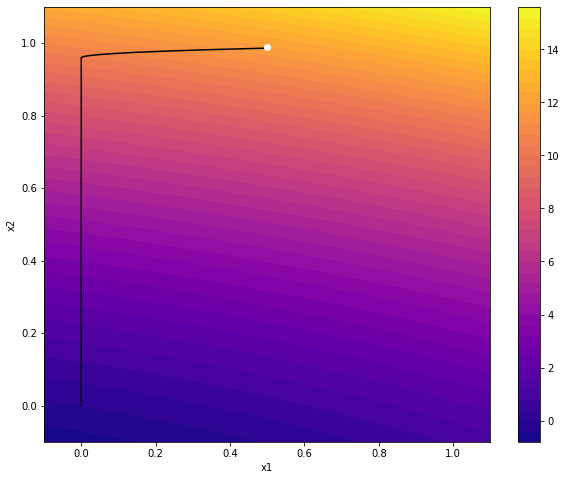

In [25]:
plot_2d(H, q, x, lb, ub)

# MIQP with constraints

## 1. Create the solver

In [26]:
solver = hmip.HopfieldSolver()

## 2. Create the problem 

$$\begin{array}{c}
\min_{x} {x^T H x + q^T x} \\\
\text{st  } A_{eq} x = b_{eq} \\\
A_{ineq} x \leq b_{ineq} \\\
x_i \in \{0, 1\} \text{ if } \text{binary_vector}_i = 1 \text{ otherwise } x_i \in \mathbb{R} \\\
lb \leq x \leq ub \\\
\end{array}$$

In [27]:
H = np.array([
    [1, 1], 
    [1, 10]
])
q = np.array([1, 6])

binary_indicator = np.array([1, 0])

ub = np.array([1, 1])
lb = np.array([0, 0])

A_eq = np.array([[3, 1], [0, 0]])
b_eq = np.array([0.3, 0])
A_ineq = np.array([[3, 1], [0, 0]])
b_ineq = np.array([0.3, 0])

penalty_eq = 1000
penalty_ineq = 10


def objective_function(x):
    return 1 / 2 * np.dot(np.dot(x.T, H), x) + np.dot(q.T, x)


def gradient(x):
    return np.dot(x, H) + q

### Use of hmip.utils:

In [28]:
H = hmip.utils.make_symmetric(H)
smoothness_coefficient = hmip.utils.smoothness_coefficient(H)

### Implement the problem in the solver

In [29]:
problem = solver.setup_optimization_problem(
    objective_function, 
    gradient, 
    lb, 
    ub, 
    binary_indicator, 
    A_eq=A_eq,
    b_eq=b_eq,  
    A_ineq=A_ineq, 
    b_ineq=b_ineq,
    smoothness_coef=smoothness_coefficient, 
    penalty_eq=penalty_eq,
    penalty_ineq=penalty_ineq
)

Set up optimization problem ....
.... Optimization problem set up.


## 3. Solve the problem

In [30]:
x, x_h, f_val_hist, step_size, other_dict = solver.solve(problem)

Solving optimization problem ....
Computing the dual variable ....
precision: 0.0009438532638509356
precision dual: 3.33
precision: 0.0009541468300227618
precision dual: 2.9970000000000003
precision: 0.0009448826204681571
precision dual: 2.6973000000000003
precision: 0.0009522205894545915
precision dual: 2.4275700000000002
precision: 0.0009440488416082027
precision dual: 2.1848130000000006
precision: 0.0009508024503735446
precision dual: 1.9663317000000002
precision: 0.0009447242024847591
precision dual: 1.7696985300000003
precision: 0.000945335358177468
precision dual: 1.5927286770000006
precision: 0.0009441771601747528
precision dual: 1.4334558093000005
precision: 0.0009486082028856702
precision dual: 1.2901102283700003
precision: 0.0009446202644458612
precision dual: 1.1610992055330003
precision: 0.0009431859002020825
precision dual: 1.0449892849797005
precision: 0.000944261349986264
precision dual: 0.9404903564817302
precision: 0.0009471685571089128
precision dual: 0.84644132083355

## 4. Plot

In [31]:
def plot_2d(H, q, x, lb, ub, A_eq=None, b_eq=None, A_ineq=None, b_ineq=None):
    
    def objective_function_2d(x_1, x_2, H, q):
        return 1 / 2 * (H[0, 0] * x_1 ** 2 + H[1, 1] * x_2 ** 2 + 2 * H[0, 1] * x_1 * x_2) + q[0] * x_1 + q[1] * x_2

    x_1 = np.linspace(-0.1 + lb[0], ub[0] + 0.1, num=500).reshape((1, -1))    
    x_2 = np.linspace(-0.1 + lb[1], ub[1] + 0.1, num=500).reshape((1, -1))
    x_meshgrid_1, x_meshgrid_2 = np.meshgrid(x_1, x_2)
    
    objective = objective_function_2d(x_meshgrid_1, x_meshgrid_2, H, q)
    
    plt.figure(figsize=(10, 8))
    plt.contourf(x_meshgrid_1, x_meshgrid_2, objective, 50, cmap='plasma')
    plt.colorbar()
    
    if A_eq is not None and b_eq is not None:
        t_eq = np.linspace(-0.1 + lb[0], ub[0] + 0.1, num=500)
        plt.plot(t_eq, ((b_eq[0] - t_eq * A_eq[0, 0]) / A_eq[0, 1]), 'white')
        
    if A_ineq is not None and b_ineq is not None:
        t_ineq = np.linspace(-0.1 + lb[0], ub[0] + 0.1, num=500)
        plt.plot(t_ineq, ((b_ineq[0] - t_ineq * A_ineq[0, 0]) / A_ineq[0, 1]), 'yellow')
        
    plt.plot(x[0, :], x[1, :], 'black')
    plt.plot(x[0, 0], x[1, 0], 'bo', markersize=6, color='white')
    plt.plot(x[0, - 1], x[1, - 1],
             'x', markersize=10, color='white')
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.xlim((lb[0] - 0.1, ub[0] + 0.1))
    plt.ylim((lb[1] - 0.1, ub[1] + 0.1))
    plt.show()

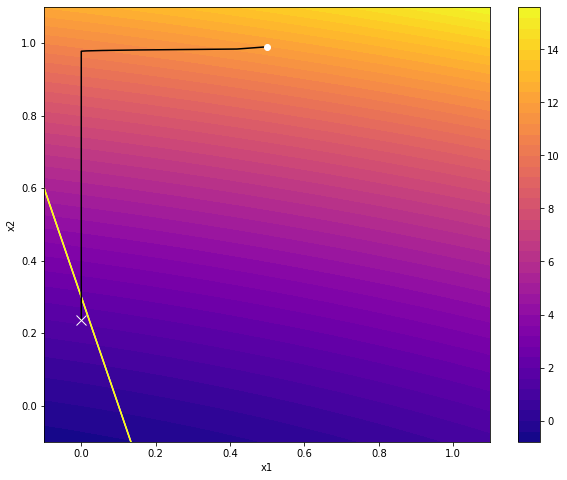

In [32]:
plot_2d(H, q, x, lb, ub, A_eq=A_eq, b_eq=b_eq, A_ineq=A_ineq, b_ineq=b_ineq)

### Another problem 

We just change the binary variable

In [35]:
binary_indicator = np.array([0, 1])

problem = solver.setup_optimization_problem(
    objective_function, 
    gradient, 
    lb, 
    ub, 
    binary_indicator, 
    A_eq=A_eq,
    b_eq=b_eq, 
    A_ineq=A_ineq, 
    b_ineq=b_ineq,
    smoothness_coef=smoothness_coefficient, 
    penalty_eq=penalty_eq,
    penalty_ineq=penalty_ineq
)

x, x_h, f_val_hist, step_size, other_dict = solver.solve(problem)

Set up optimization problem ....
.... Optimization problem set up.
Solving optimization problem ....
Computing the dual variable ....
precision: 0.0006985516250930194
precision dual: 3.33
precision: 0.0007397927016007278
precision dual: 2.9970000000000003
precision: 0.0006988098347666689
precision dual: 2.6973000000000003
precision: 0.0007326878523342214
precision dual: 2.4275700000000002
precision: 0.0006996330457212764
precision dual: 2.1848130000000006
precision: 0.0007273934714139429
precision dual: 1.9663317000000002
precision: 0.0007007291585976494
precision dual: 1.7696985300000003
precision: 0.0006983690158144444
precision dual: 1.5927286770000002
precision: 0.0006998117935831451
precision dual: 1.4334558093000005
precision: 0.0007143645196359639
precision dual: 1.2901102283700003
precision: 0.0007005355210982849
precision dual: 1.1610992055330003
precision: 0.0006984797139621718
precision dual: 1.0449892849797002
precision: 0.0006999366000179321
precision dual: 0.9404903564817

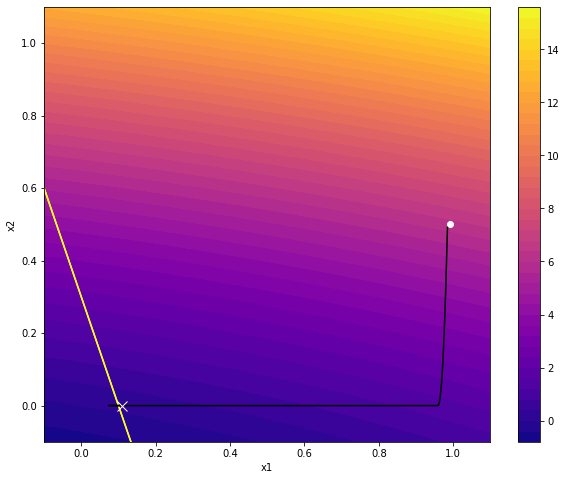

In [34]:
plot_2d(H, q, x, lb, ub,A_eq=A_eq, b_eq=b_eq, A_ineq=A_ineq, b_ineq=b_ineq)